In [1]:
from matplotlib.dates import date2num, num2date
from matplotlib.colors import ListedColormap
from matplotlib import dates as mdates
from matplotlib.patches import Patch
from matplotlib import pyplot as plt
from matplotlib import ticker

import pandas as pd
import numpy as np
import sys
import os

sys.path.insert(0, "..")
from global_config import config

results_dir   = config.get_property('results_dir')
data_dir      = config.get_property('data_dir')

In [2]:
path_to_frcst_1 = os.path.join(results_dir, "forecast", "arima")
path_to_frcst_2 = os.path.join(results_dir, "forecast", "eakf_model1")
path_to_frcst_3 = os.path.join(results_dir, "forecast", "eakf_model2")
path_to_frcst_4 = os.path.join(results_dir, "forecast", "eakf_model3")

evals_df        = pd.read_csv(os.path.join(results_dir, "forecast", "evaluation", "scores.csv"), parse_dates=["frsct_date"])
usa_df          = pd.read_csv(os.path.join(data_dir, "processed_data_us.csv"), parse_dates=["date"])
dates_forecasts = usa_df.date[11:].values

In [3]:
from utils.utils_eval import compute_evals

usa_df["date"] = pd.to_datetime(usa_df["date"])

evals_w_df = []
for idx, date in enumerate(dates_forecasts[:-6]):

    ts       = pd.to_datetime(str(date))
    d        = ts.strftime('%Y-%m-%d')
    date_str = pd.to_datetime(date).strftime("%Y-%m-%d")

    path_to_save_ens = os.path.join(results_dir, "forecast", "ensemble", "equal_weights")
    ens_df           = pd.read_csv(os.path.join(path_to_save_ens,  f"{date_str}.csv"), parse_dates=["date"])

    dates_use = ens_df.date
    fit_data  = usa_df[usa_df.date.isin((list(dates_use)))].set_index("date")[["total"]]

    eval1_df               = compute_evals(ens_df, fit_data)
    eval1_df["frsct_date"] = date
    eval1_df["method"]     = "equal_weights_ensemble"
    evals_w_df.append(eval1_df.reset_index())

evals_w_df = pd.concat(evals_w_df)
evals_w_df.to_csv(os.path.join(results_dir, "forecast", "evaluation", "scores_equal_weights.csv"), index=False)


## Performance Ensemble all past performance

In [4]:
forecast_windows = {"1m": 1, "2m": 2, "3m": 3, "4m": 4, "5m": 5, "6m": 6}
evals_w_df       = []
dates_use        = dates_forecasts[6:]

for idx_date_use, date_use in enumerate(dates_use[:-6]):
    for fw in list(list(forecast_windows.keys())):

        date_str         = pd.to_datetime(date_use).strftime("%Y-%m-%d")
        path_to_save_ens = os.path.join(results_dir, "forecast", "ensemble", "all_past", f"wis", fw)

        try:
            ens_df           = pd.read_csv((os.path.join(path_to_save_ens,  f"{date_str}.csv")))
        except:
            continue

        date_fit = ens_df.date
        fit_data = usa_df[usa_df.date.isin((list(date_fit)))].set_index("date")[["total"]]

        eval1_df               = compute_evals(ens_df, fit_data)
        eval1_df["frsct_date"] = date
        eval1_df["method"]     = f"all_past_ens"

        eval1_df["eval_horizon_ensemble" ] = fw
        eval1_df["forecast_date"] = date_use
        eval1_df["score"]         = "wis"
        eval1_df["type_ensemble"] = f"all_past_ens"
        evals_w_df.append(eval1_df.reset_index())

evals_w_df = pd.concat(evals_w_df)
evals_w_df.to_csv(os.path.join(results_dir, "forecast", "evaluation", "scores_all_past.csv"), index=False)

## Performance Ensemble K-past performance

In [5]:
evals_w_df      = []
dates_use       = dates_forecasts[6:]
past_points_use = [2, 3, 4, 5, 6]

for K in past_points_use:
    for idx_date_use, date_use in enumerate(dates_use[:-6]):
        for fw in list(list(forecast_windows.keys())):
            date_str         = pd.to_datetime(date_use).strftime("%Y-%m-%d")
            path_to_save_ens = os.path.join(results_dir, "forecast", "ensemble", f"{K}_months_past", fw)

            try:
                ens_df       = pd.read_csv((os.path.join(path_to_save_ens,  f"{date_str}.csv")))
            except:
                print("date_str")
                continue

            date_fit = ens_df.date
            fit_data = usa_df[usa_df.date.isin((list(date_fit)))].set_index("date")[["total"]]

            eval1_df                           = compute_evals(ens_df, fit_data)
            eval1_df["frsct_date"]             = date
            eval1_df["method"]                 = f"{K}_past_ens"
            eval1_df["eval_horizon_ensemble" ] = fw
            eval1_df["forecast_date"]          = date_use
            eval1_df["score"]                  = "wis"
            eval1_df["type_ensemble"]          = f"{K}_past_ens"
            evals_w_df.append(eval1_df.reset_index())
evals_w_df = pd.concat(evals_w_df)
evals_w_df.to_csv(os.path.join(results_dir, "forecast", "evaluation", "scores_K_past.csv"), index=False)


# plot performance

In [6]:
all_past_df               = pd.read_csv(os.path.join(results_dir, "forecast", "evaluation",  "scores_all_past.csv"), parse_dates=["frsct_date"])
all_past_df["frsct_date"] = all_past_df["forecast_date"]

eq_weights_df             = pd.read_csv( os.path.join(results_dir, "forecast", "evaluation", "scores_equal_weights.csv"), parse_dates=["frsct_date"])
k_past_df                 = pd.read_csv(os.path.join(results_dir, "forecast", "evaluation",  "scores_K_past.csv"), parse_dates=["frsct_date"])
k_past_df["frsct_date"]   = k_past_df["forecast_date"]

k_past                    = ['2_past_ens', '3_past_ens', '4_past_ens', '5_past_ens', '6_past_ens']
k_past_df                 = pd.concat([k_past_df, all_past_df])

In [7]:
%config InlineBackend.figure_format ='retina'
from matplotlib.dates import date2num, num2date
from matplotlib.colors import ListedColormap
from matplotlib import dates as mdates
from matplotlib.patches import Patch
from matplotlib import pyplot as plt
from matplotlib import ticker

import seaborn as sns

weekdict = {'1m': 1, '2m': 2, '3m': 3, '4m': 4, '5m': 5, '6m': 6}

def format_type_label_ensmelbe(s):
    if s == "all_past_ens":
        return "All past"
    else:
        return s[0]+" months"

import pylab

NUM_COLORS = 6
cm         = pylab.get_cmap('gist_ncar')
paletteee  = [cm(idx_c/NUM_COLORS) for idx_c in range(NUM_COLORS)]


/var/folders/7p/jp6xqkvn5wb6ddl1fn0bhs980000gn/T/ipykernel_4590/274071408.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_stats_week["forecast_date"] = pd.to_datetime(df_stats_week["forecast_date"])
/var/folders/7p/jp6xqkvn5wb6ddl1fn0bhs980000gn/T/ipykernel_4590/274071408.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_stats_week["forecast_date"] = pd.to_datetime(df_stats_week["forecast_date"])
/var/folders/7p/jp6xqkvn5wb6ddl1fn0bhs980000gn/T/ipykernel_4590/274071408.py:8: SettingWithCopyWarni

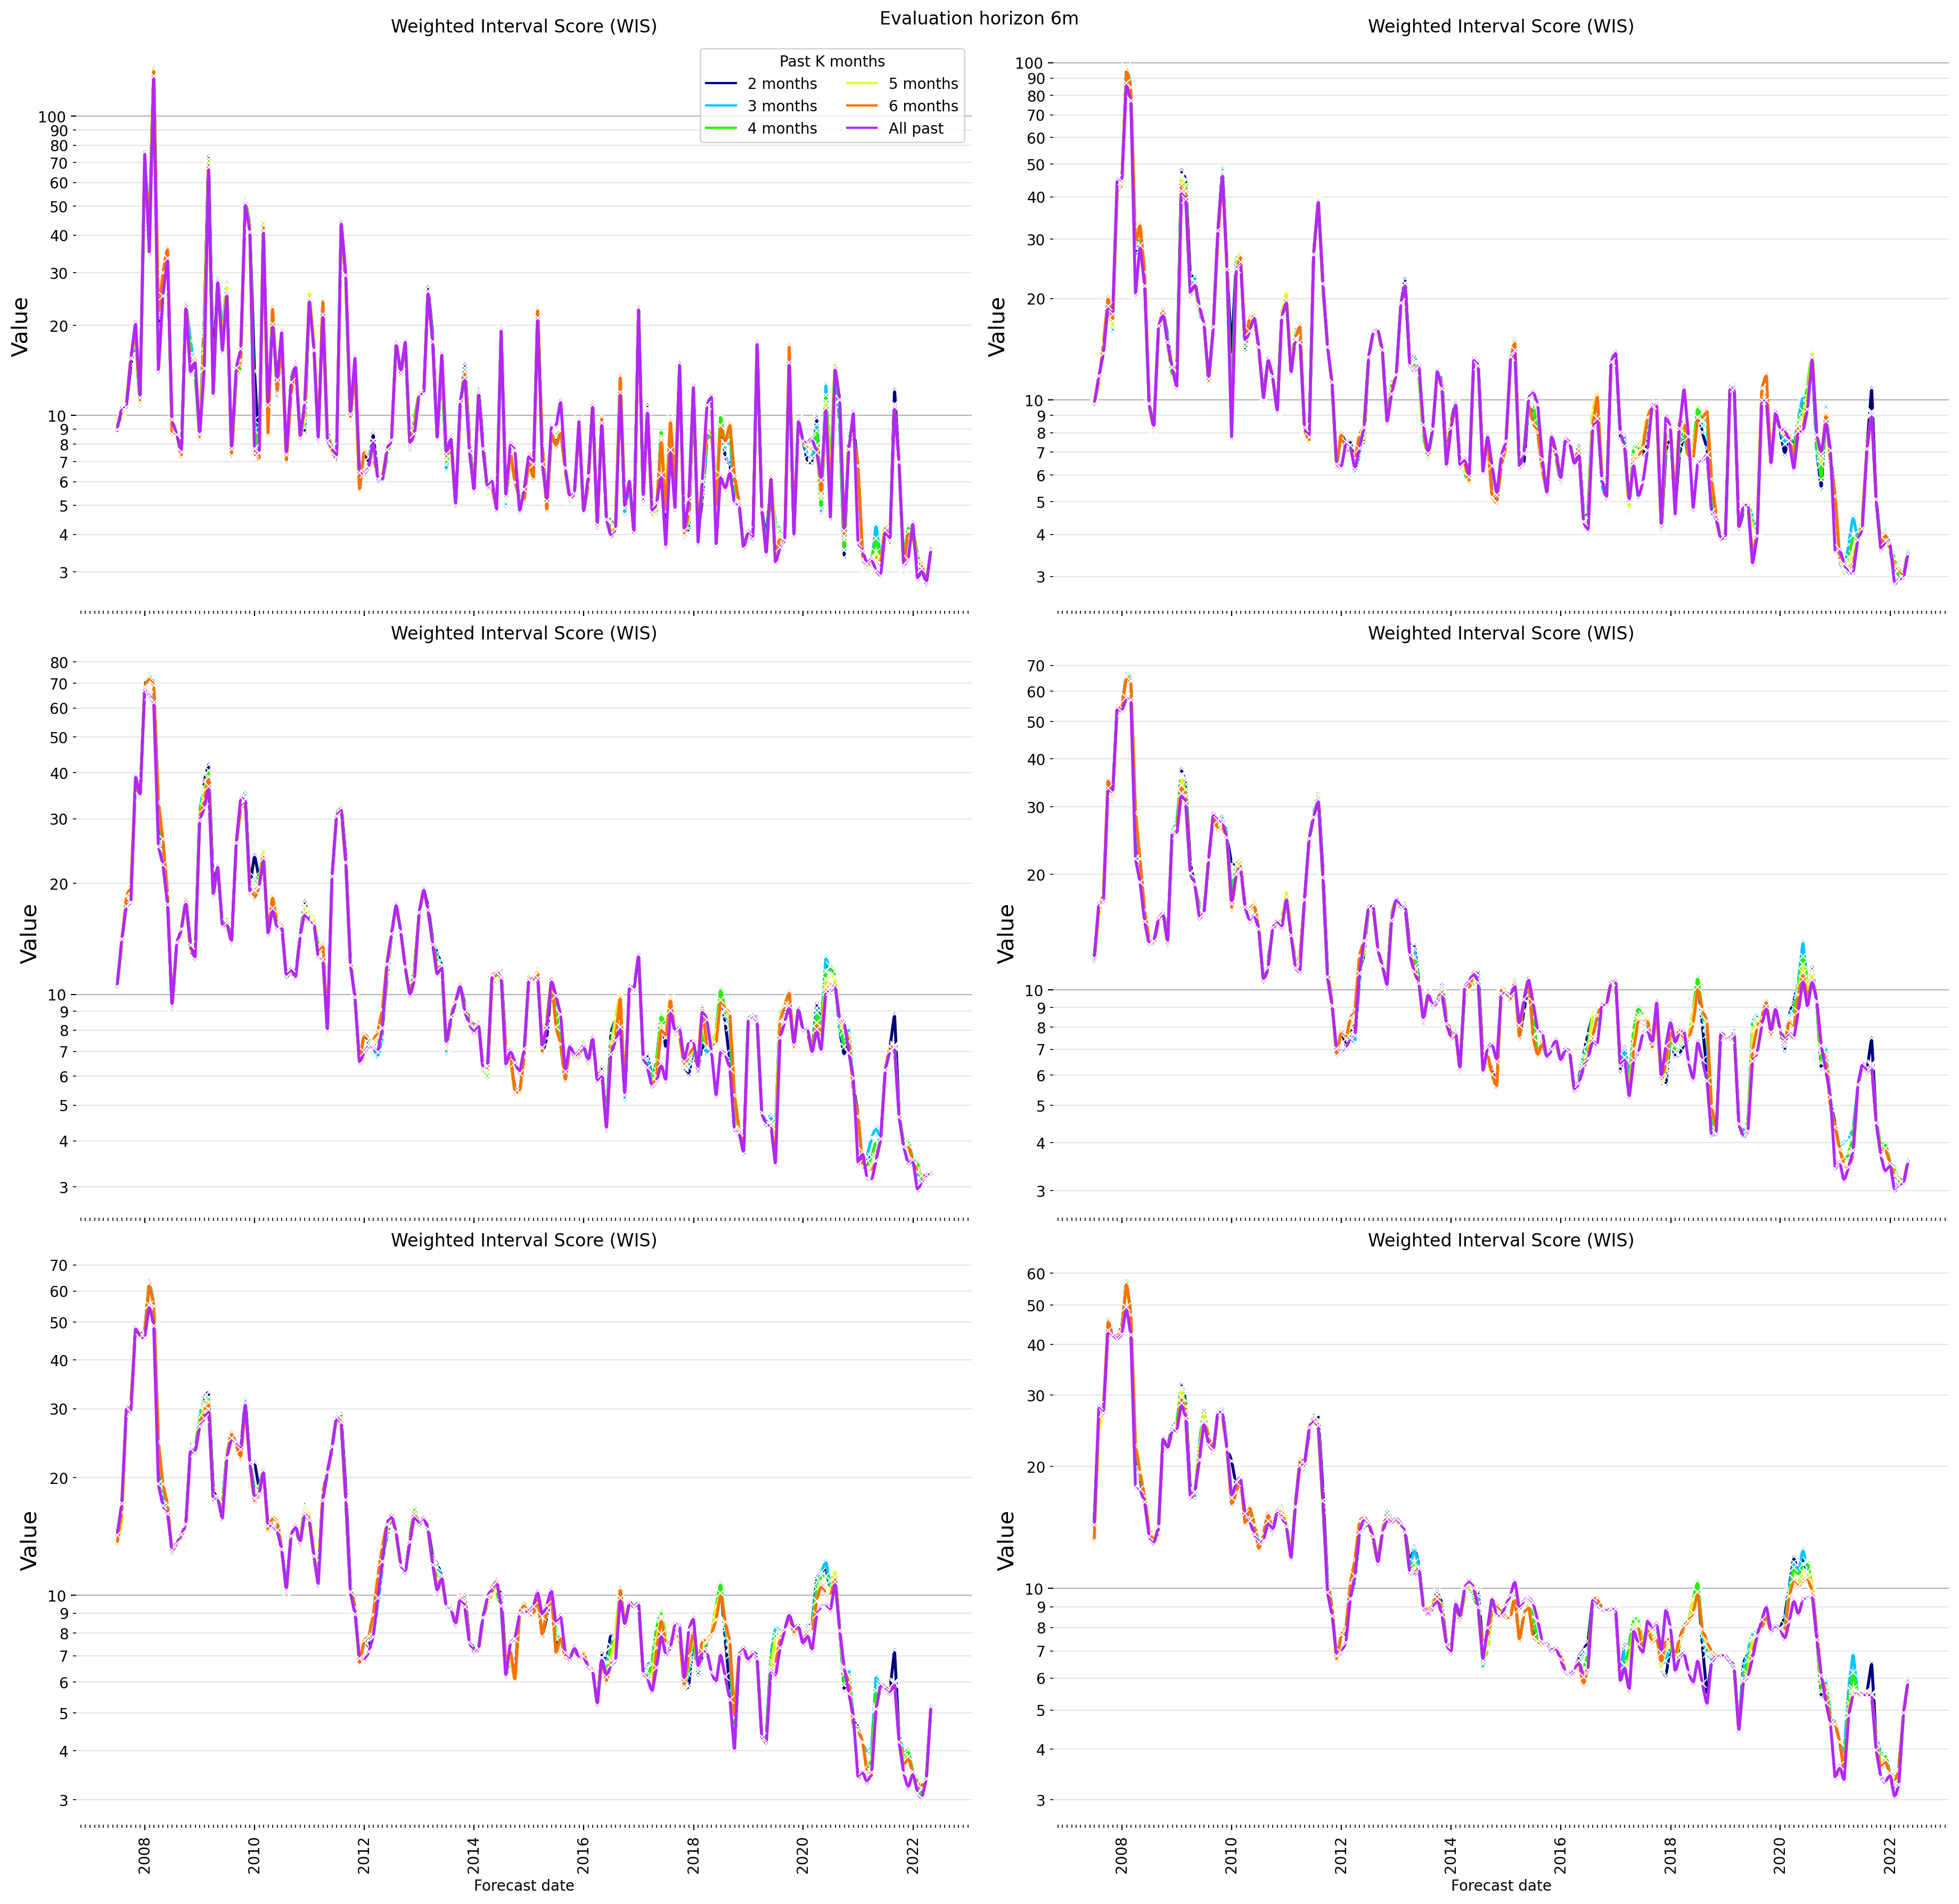

In [8]:
fig, axes = plt.subplots(3, 2, figsize=(18.5, 18.2), sharex=True)


for idx_axi, ax in enumerate(axes.flatten()): #kw in weekdict.keys():

    kw = list(weekdict.keys())[idx_axi]
    df_stats_week                  = k_past_df[k_past_df.eval_horizon==kw]
    df_stats_week["forecast_date"] = pd.to_datetime(df_stats_week["forecast_date"])
    df_stats_week                  = df_stats_week.groupby(["forecast_date", "type_ensemble"]).mean().reset_index()
    df_stats_week["type_label"]    = df_stats_week.apply(lambda x: format_type_label_ensmelbe(x.type_ensemble), axis=1)

    sns.lineplot(ax=ax, data=df_stats_week, x="forecast_date", y="wis", marker='x', linestyle='-', hue="type_label", palette=paletteee, lw=2)

    ax.set_title('Weighted Interval Score (WIS)')
    ax.set_xlabel("Forecast date")
    ax.set_yscale("log")
    ax.legend()

    fig.suptitle(f"Evaluation horizon {kw}")

for idx_ax, ax in enumerate(axes.flatten()):
    ax.xaxis.set_minor_locator(mdates.MonthLocator())
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.grid(which='major', axis='y', c='k', alpha=.3, zorder=-2)
    ax.grid(which='minor', axis='y', c='k', alpha=.1, zorder=-2)
    ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.0f}"))
    ax.yaxis.set_minor_formatter(ticker.StrMethodFormatter("{x:.0f}"))
    ax.set_ylabel('Value', size=15)
    ax.tick_params(which='both', axis='both', labelrotation=0)
    ax.tick_params(which='both', axis='x', labelrotation=90)

    if idx_ax==0:
        ax.legend(loc='upper right', title="Past K months", ncol=2)
    else:
        ax.legend_.remove()
    ax.axhline(y=0, color="k", lw=1.5, linestyle="--")

plt.tight_layout()
    #fig.savefig(os.path.join(results_dir, "forecast", "ensemble", f"window_size_eval_{kw}.png"), dpi=300, transparent=True)


In [9]:
scores_models_df = pd.read_csv(os.path.join(results_dir, "forecast", "evaluation", "scores.csv"), parse_dates=["frsct_date"])
model_stats_df   = scores_models_df.copy()
ens_stats_df     = k_past_df.copy()

eq_weights_resume_df = eq_weights_df
ens_stats_df         = ens_stats_df[ens_stats_df.method.isin(["2_past_ens", "3_past_ens", "4_past_ens", "5_past_ens", "6_past_ens", "all_past_ens"])]
ens_stats_df         = ens_stats_df[ens_stats_df.eval_horizon_ensemble=="6m"]
plot_bars_df         = pd.concat([model_stats_df, ens_stats_df, eq_weights_resume_df])


# All time series performance

In [10]:
years          = ['2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020']
pre_vac_years  = years[:6]
post_vac_years = years[6:]


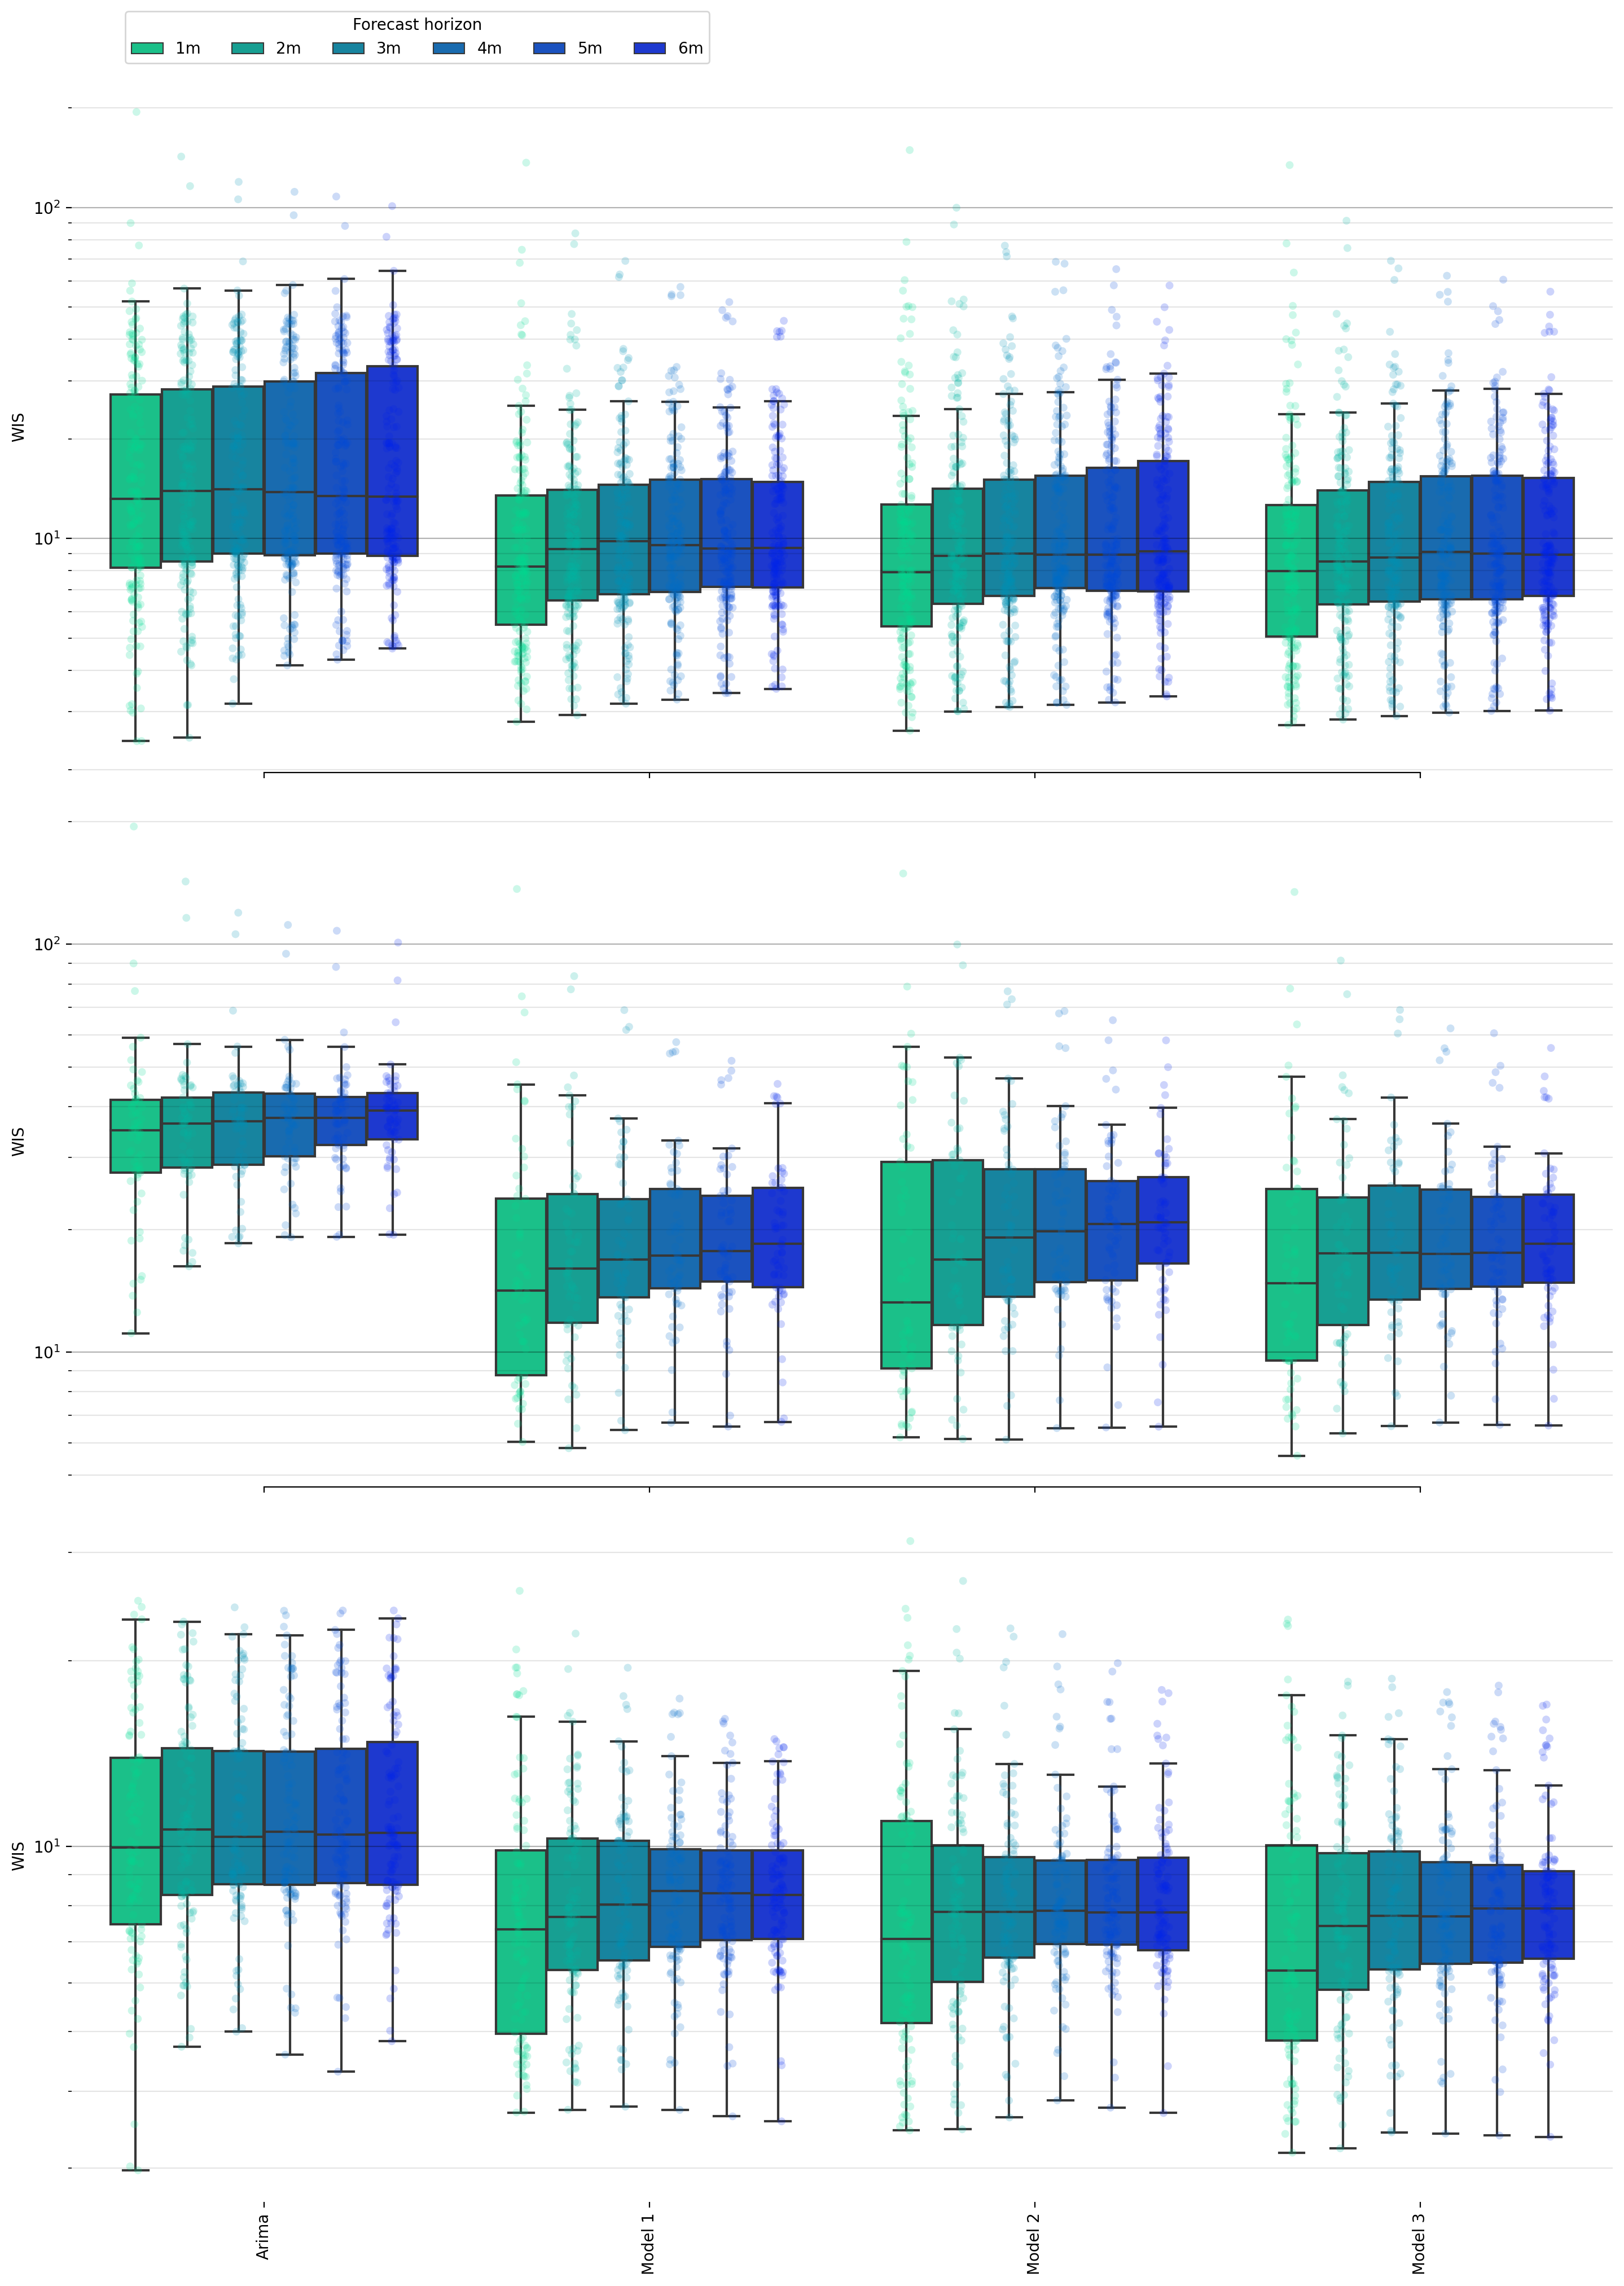

In [11]:
bars_all_period_df = []

name_cols    = {"arima": "Arima", "eakf_model1": "Model 1", "eakf_model2": "Model 2", "eakf_model3": "Model 3",
                "2_past_ens": "Ens. (2 Months)", "3_past_ens": "Ens. (3 Months)", "4_past_ens": "Ens. (4 Months)",
                "5_past_ens": "Ens. (5 Months)", "6_past_ens": "Ens. (6 Months)", "all_past_ens": "Ens. (All past)", "equal_weights_ensemble": "Ens. (Eq. Weights)"}

plot_bars_df["method_plot"] = plot_bars_df["method"].apply(lambda x: name_cols[x])
plot_bars_df["period"]      = "All"
plot_bars_df["frsct_date"]  = pd.to_datetime(plot_bars_df["frsct_date"])
plot_bars_df['year']        = plot_bars_df.frsct_date.dt.year
plot_bars_df['year']        = plot_bars_df.year.apply(lambda x: str(x))

bars_all_period_df.append(plot_bars_df)

models_plt = ["arima", "eakf_model1", "eakf_model2", "eakf_model3"]

fig, ax = plt.subplots(3, 1, figsize=(14.5, 20.2), sharex=True)

plt_bar_df = plot_bars_df[plot_bars_df.method.isin(models_plt)]
sns.boxplot(ax=ax[0], data=plt_bar_df, x="method_plot", y="wis", hue="eval_horizon", palette="winter_r", dodge=True, fliersize=0)
sns.stripplot(ax=ax[0], data=plt_bar_df, x="method_plot", y="wis", hue="eval_horizon", palette="winter_r", dodge=True, linewidth=0, alpha=.2, label=None)


plt_bar_df = plot_bars_df[plot_bars_df.method.isin(models_plt)]
plt_bar_df = plt_bar_df[plt_bar_df.year.isin(pre_vac_years)]
sns.boxplot(ax=ax[1], data=plt_bar_df, x="method_plot", y="wis", hue="eval_horizon", palette="winter_r", dodge=True, fliersize=0)
sns.stripplot(ax=ax[1], data=plt_bar_df, x="method_plot", y="wis", hue="eval_horizon", palette="winter_r", dodge=True, linewidth=0, alpha=.2, label=None)


plt_bar_df = plot_bars_df[plot_bars_df.method.isin(models_plt)]
plt_bar_df = plt_bar_df[plt_bar_df.year.isin(post_vac_years)]
sns.boxplot(ax=ax[2], data=plt_bar_df, x="method_plot", y="wis", hue="eval_horizon", palette="winter_r", dodge=True, fliersize=0)
sns.stripplot(ax=ax[2], data=plt_bar_df, x="method_plot", y="wis", hue="eval_horizon", palette="winter_r", dodge=True, linewidth=0, alpha=.2, label=None)


for idx_axi, axi in enumerate(ax):
    axi.grid(which='major', axis='y', c='k', alpha=.3, zorder=-2)
    axi.grid(which='minor', axis='y', c='k', alpha=.1, zorder=-2)

    sns.despine(trim=True, left=True)
    axi.spines['bottom'].set_visible(False)
    axi.spines['right'].set_visible(False)
    axi.spines['left'].set_visible(False)
    axi.spines['top'].set_visible(False)

    axi.tick_params(which='both', axis='x', labelrotation=90)
    axi.legend(title="Forecast horizon", ncol=3)
    axi.set_xlabel(None)
    axi.set_ylabel("WIS")
    axi.set_yscale("log")
    if idx_axi==0:
        handles, labels = axi.get_legend_handles_labels()
        axi.legend(handles[:-6], labels[:-6], title="Forecast horizon", ncol=6, bbox_to_anchor=(0.035, 1.1), loc="upper left", borderaxespad=0)
    else:
        axi.legend().remove()

plt.tight_layout()


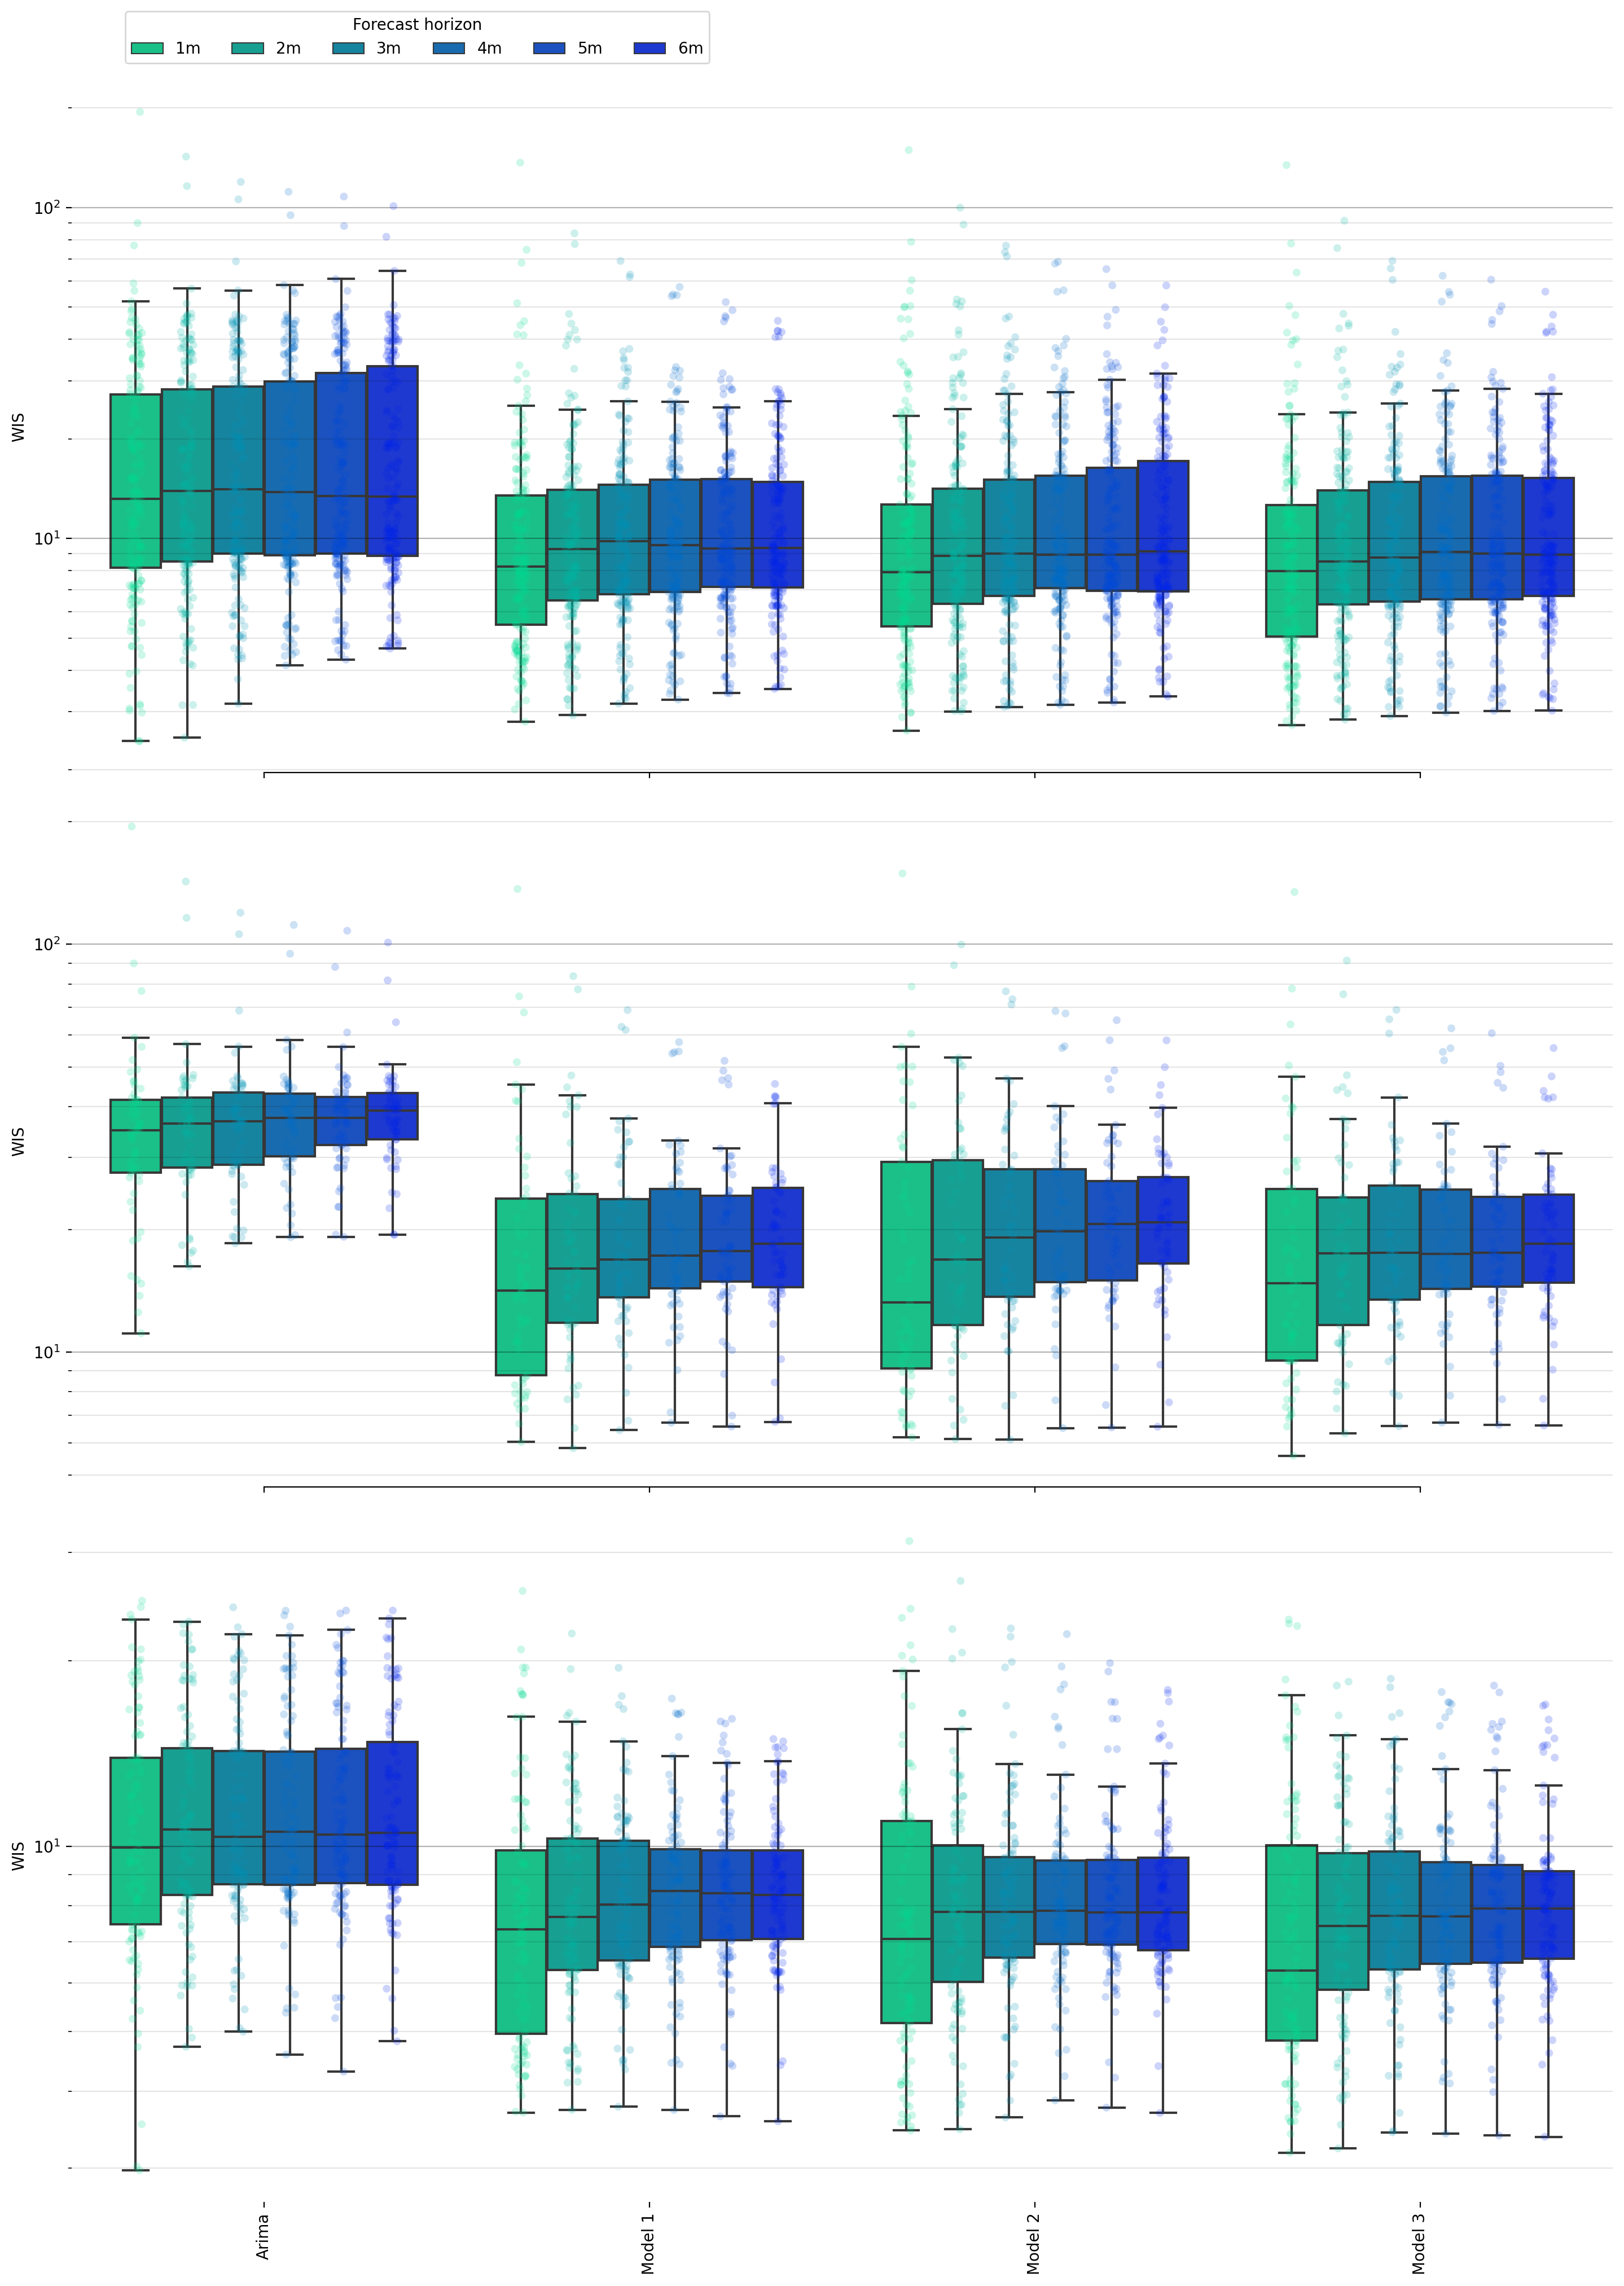

In [12]:
bars_all_period_df = []

name_cols    = {"arima": "Arima", "eakf_model1": "Model 1", "eakf_model2": "Model 2", "eakf_model3": "Model 3",
                "2_past_ens": "Ens. (2 Months)", "3_past_ens": "Ens. (3 Months)", "4_past_ens": "Ens. (4 Months)",
                "5_past_ens": "Ens. (5 Months)", "6_past_ens": "Ens. (6 Months)", "all_past_ens": "Ens. (All past)", "equal_weights_ensemble": "Ens. (Eq. Weights)"}

plot_bars_df["method_plot"] = plot_bars_df["method"].apply(lambda x: name_cols[x])
plot_bars_df["period"]      = "All"
plot_bars_df["frsct_date"]  = pd.to_datetime(plot_bars_df["frsct_date"])
plot_bars_df['year']        = plot_bars_df.frsct_date.dt.year
plot_bars_df['year']        = plot_bars_df.year.apply(lambda x: str(x))

bars_all_period_df.append(plot_bars_df)

models_plt = ["arima", "eakf_model1", "eakf_model2", "eakf_model3"]

fig, ax = plt.subplots(3, 1, figsize=(14.5, 20.2), sharex=True)

plt_bar_df = plot_bars_df[plot_bars_df.method.isin(models_plt)]
sns.boxplot(ax=ax[0], data=plt_bar_df, x="method_plot", y="wis", hue="eval_horizon", palette="winter_r", dodge=True, fliersize=0)
sns.stripplot(ax=ax[0], data=plt_bar_df, x="method_plot", y="wis", hue="eval_horizon", palette="winter_r", dodge=True, linewidth=0, alpha=.2, label=None)

plt_bar_df = plot_bars_df[plot_bars_df.method.isin(models_plt)]
plt_bar_df = plt_bar_df[plt_bar_df.year.isin(pre_vac_years)]
sns.boxplot(ax=ax[1], data=plt_bar_df, x="method_plot", y="wis", hue="eval_horizon", palette="winter_r", dodge=True, fliersize=0)
sns.stripplot(ax=ax[1], data=plt_bar_df, x="method_plot", y="wis", hue="eval_horizon", palette="winter_r", dodge=True, linewidth=0, alpha=.2, label=None)

plt_bar_df = plot_bars_df[plot_bars_df.method.isin(models_plt)]
plt_bar_df = plt_bar_df[plt_bar_df.year.isin(post_vac_years)]
sns.boxplot(ax=ax[2], data=plt_bar_df, x="method_plot", y="wis", hue="eval_horizon", palette="winter_r", dodge=True, fliersize=0)
sns.stripplot(ax=ax[2], data=plt_bar_df, x="method_plot", y="wis", hue="eval_horizon", palette="winter_r", dodge=True, linewidth=0, alpha=.2, label=None)


for idx_axi, axi in enumerate(ax):
    axi.grid(which='major', axis='y', c='k', alpha=.3, zorder=-2)
    axi.grid(which='minor', axis='y', c='k', alpha=.1, zorder=-2)

    sns.despine(trim=True, left=True)
    axi.spines['bottom'].set_visible(False)
    axi.spines['right'].set_visible(False)
    axi.spines['left'].set_visible(False)
    axi.spines['top'].set_visible(False)

    axi.tick_params(which='both', axis='x', labelrotation=90)
    axi.legend(title="Forecast horizon", ncol=3)
    axi.set_xlabel(None)
    axi.set_ylabel("WIS")
    axi.set_yscale("log")
    if idx_axi==0:
        handles, labels = axi.get_legend_handles_labels()
        axi.legend(handles[:-6], labels[:-6], title="Forecast horizon", ncol=6, bbox_to_anchor=(0.035, 1.1), loc="upper left", borderaxespad=0)
    else:
        axi.legend().remove()

plt.tight_layout()


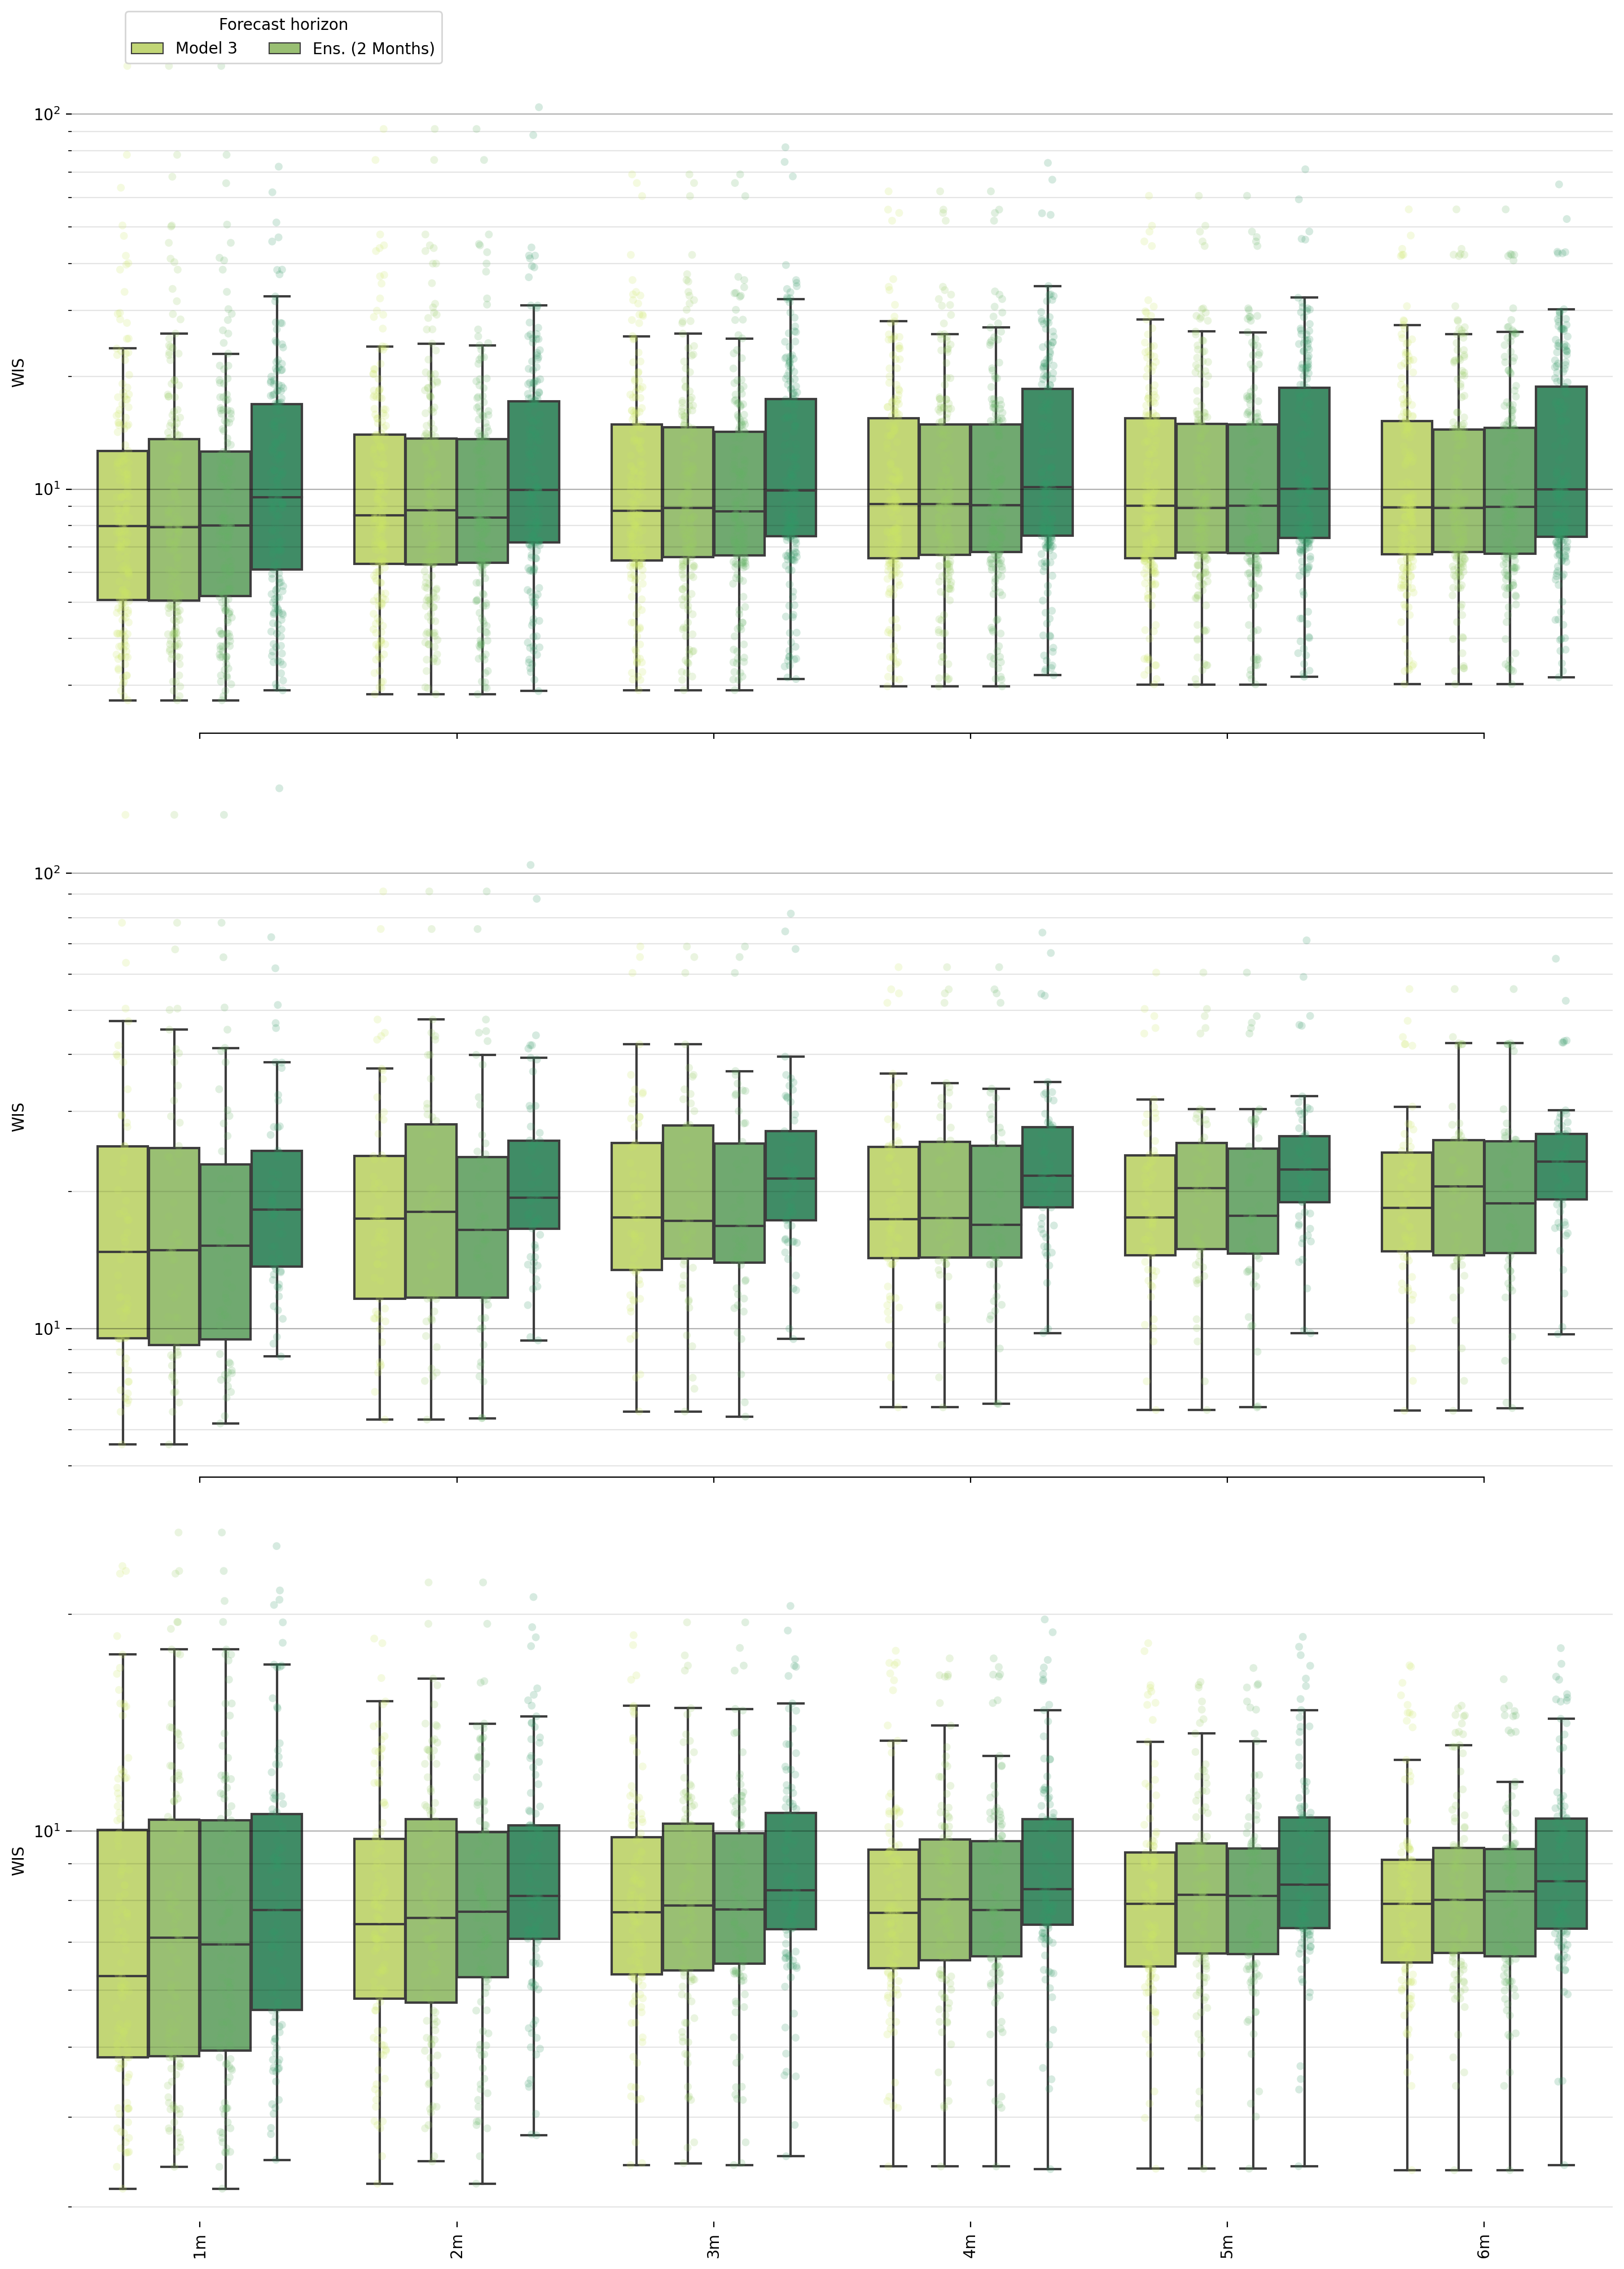

In [13]:
bars_all_period_df = []

name_cols    = {"arima": "Arima", "eakf_model1": "Model 1", "eakf_model2": "Model 2", "eakf_model3": "Model 3",
                "2_past_ens": "Ens. (2 Months)", "3_past_ens": "Ens. (3 Months)", "4_past_ens": "Ens. (4 Months)",
                "5_past_ens": "Ens. (5 Months)", "6_past_ens": "Ens. (6 Months)", "all_past_ens": "Ens. (All past)", "equal_weights_ensemble": "Ens. (Eq. Weights)"}

plot_bars_df["method_plot"] = plot_bars_df["method"].apply(lambda x: name_cols[x])
plot_bars_df["period"] = "All"
plot_bars_df["frsct_date"] = pd.to_datetime(plot_bars_df["frsct_date"])
plot_bars_df['year'] = plot_bars_df.frsct_date.dt.year
plot_bars_df['year'] = plot_bars_df.year.apply(lambda x: str(x))

bars_all_period_df.append(plot_bars_df)

models_plt = ["eakf_model3", "2_past_ens", "all_past_ens", "equal_weights_ensemble"]

fig, ax = plt.subplots(3, 1, figsize=(14.5, 20.2), sharex=True)

plt_bar_df = plot_bars_df[plot_bars_df.method.isin(models_plt)]
sns.boxplot(ax=ax[0], data=plt_bar_df, x="eval_horizon", y="wis", hue="method_plot", palette="summer_r", dodge=True, fliersize=0)
sns.stripplot(ax=ax[0], data=plt_bar_df, x="eval_horizon", y="wis", hue="method_plot", palette="summer_r", dodge=True, linewidth=0, alpha=.2, label=None)


plt_bar_df = plot_bars_df[plot_bars_df.method.isin(models_plt)]
plt_bar_df = plt_bar_df[plt_bar_df.year.isin(pre_vac_years)]
sns.boxplot(ax=ax[1], data=plt_bar_df, x="eval_horizon", y="wis", hue="method_plot", palette="summer_r", dodge=True, fliersize=0)
sns.stripplot(ax=ax[1], data=plt_bar_df, x="eval_horizon", y="wis", hue="method_plot", palette="summer_r", dodge=True, linewidth=0, alpha=.2, label=None)


plt_bar_df = plot_bars_df[plot_bars_df.method.isin(models_plt)]
plt_bar_df = plt_bar_df[plt_bar_df.year.isin(post_vac_years)]
sns.boxplot(ax=ax[2], data=plt_bar_df, x="eval_horizon", y="wis", hue="method_plot", palette="summer_r", dodge=True, fliersize=0)
sns.stripplot(ax=ax[2], data=plt_bar_df, x="eval_horizon", y="wis", hue="method_plot", palette="summer_r", dodge=True, linewidth=0, alpha=.2, label=None)

for idx_axi, axi in enumerate(ax):
    axi.grid(which='major', axis='y', c='k', alpha=.3, zorder=-2)
    axi.grid(which='minor', axis='y', c='k', alpha=.1, zorder=-2)

    sns.despine(trim=True, left=True)
    axi.spines['bottom'].set_visible(False)
    axi.spines['right'].set_visible(False)
    axi.spines['left'].set_visible(False)
    axi.spines['top'].set_visible(False)

    axi.tick_params(which='both', axis='x', labelrotation=90)
    axi.legend(title="Forecast horizon", ncol=3)
    axi.set_xlabel(None)
    axi.set_ylabel("WIS")
    axi.set_yscale("log")
    if idx_axi==0:
        handles, labels = axi.get_legend_handles_labels()
        axi.legend(handles[:-6], labels[:-6], title="Forecast horizon", ncol=6, bbox_to_anchor=(0.035, 1), loc="upper left", borderaxespad=0)
    else:
        axi.legend().remove()
plt.tight_layout()



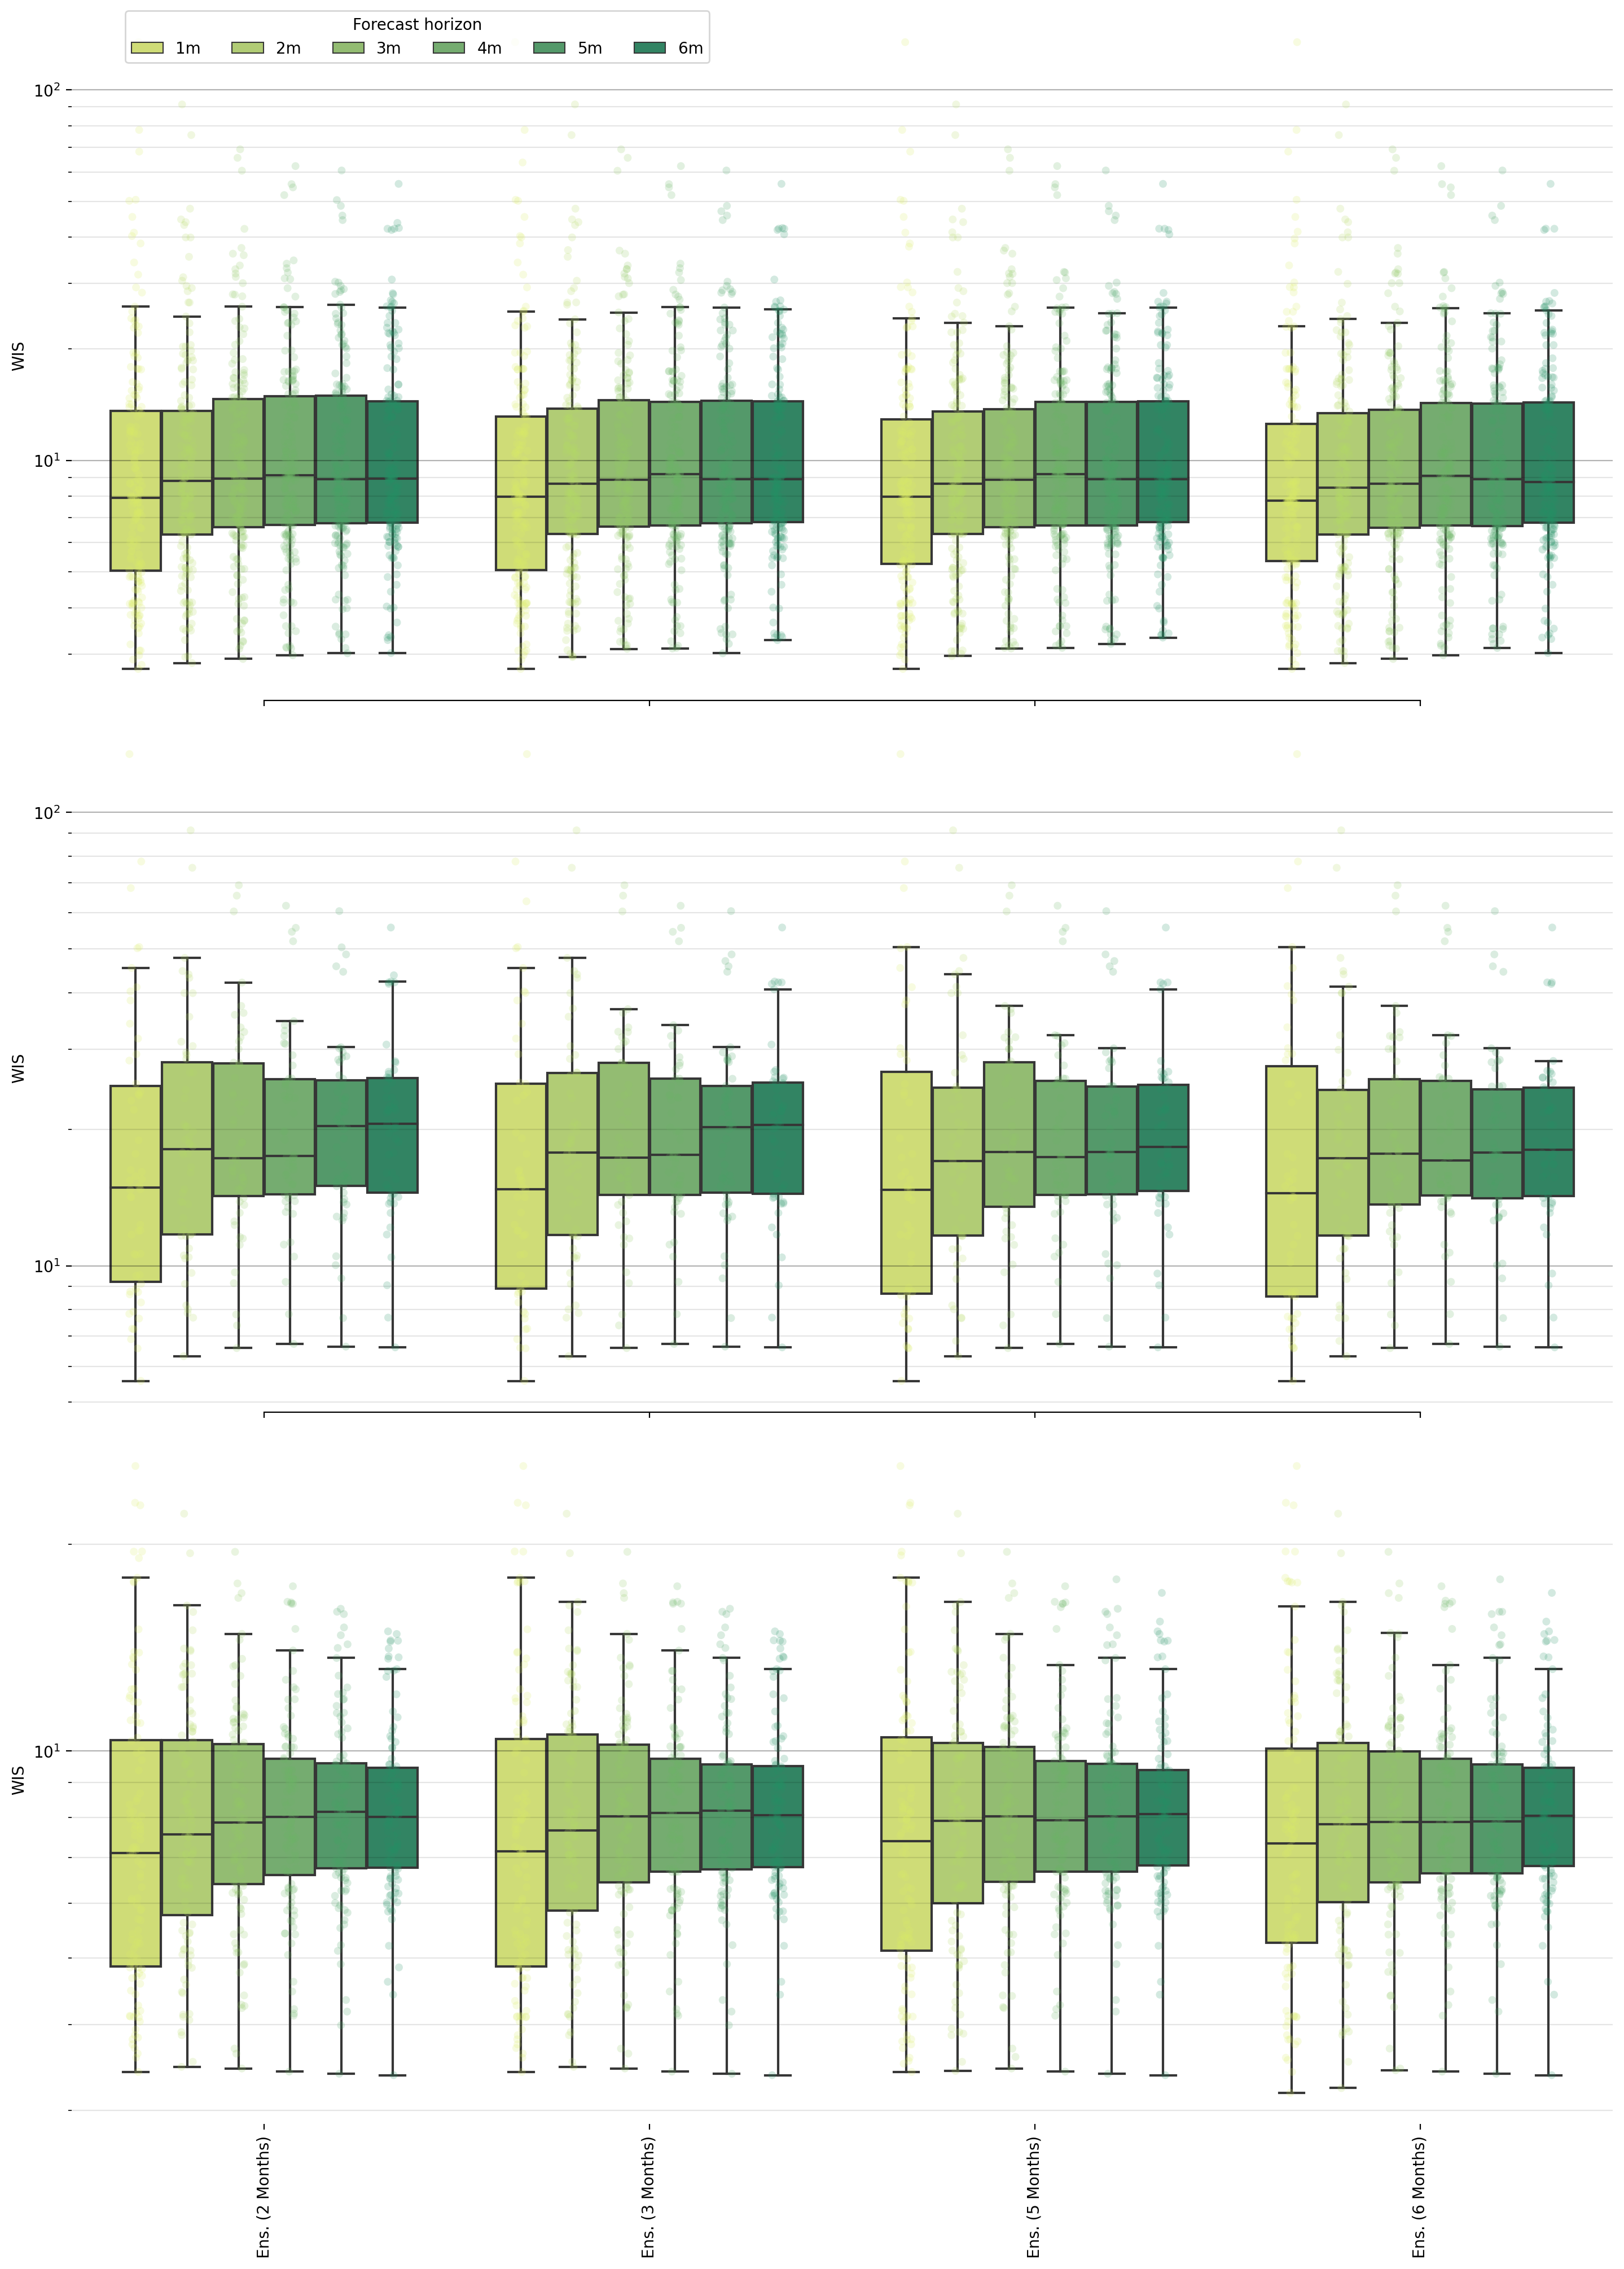

In [14]:
bars_all_period_df = []

name_cols    = {"arima": "Arima", "eakf_model1": "Model 1", "eakf_model2": "Model 2", "eakf_model3": "Model 3",
                "2_past_ens": "Ens. (2 Months)", "3_past_ens": "Ens. (3 Months)", "4_past_ens": "Ens. (4 Months)",
                "5_past_ens": "Ens. (5 Months)", "6_past_ens": "Ens. (6 Months)", "all_past_ens": "Ens. (All past)", "equal_weights_ensemble": "Ens. (Eq. Weights)"}

plot_bars_df["method_plot"] = plot_bars_df["method"].apply(lambda x: name_cols[x])
plot_bars_df["period"] = "All"
plot_bars_df["frsct_date"] = pd.to_datetime(plot_bars_df["frsct_date"])
plot_bars_df['year'] = plot_bars_df.frsct_date.dt.year
plot_bars_df['year'] = plot_bars_df.year.apply(lambda x: str(x))

bars_all_period_df.append(plot_bars_df)

models_plt = ["2_past_ens", "3_past_ens", "5_past_ens", "6_past_ens"]

fig, ax = plt.subplots(3, 1, figsize=(14.5, 20.2), sharex=True)

plt_bar_df = plot_bars_df[plot_bars_df.method.isin(models_plt)]
sns.boxplot(ax=ax[0], data=plt_bar_df, x="method_plot", y="wis", hue="eval_horizon", palette="summer_r", dodge=True, fliersize=0)
sns.stripplot(ax=ax[0], data=plt_bar_df, x="method_plot", y="wis", hue="eval_horizon", palette="summer_r", dodge=True, linewidth=0, alpha=.2, label=None)

plt_bar_df = plot_bars_df[plot_bars_df.method.isin(models_plt)]
plt_bar_df = plt_bar_df[plt_bar_df.year.isin(pre_vac_years)]
sns.boxplot(ax=ax[1], data=plt_bar_df, x="method_plot", y="wis", hue="eval_horizon", palette="summer_r", dodge=True, fliersize=0)
sns.stripplot(ax=ax[1], data=plt_bar_df, x="method_plot", y="wis", hue="eval_horizon", palette="summer_r", dodge=True, linewidth=0, alpha=.2, label=None)

plt_bar_df = plot_bars_df[plot_bars_df.method.isin(models_plt)]
plt_bar_df = plt_bar_df[plt_bar_df.year.isin(post_vac_years)]
sns.boxplot(ax=ax[2], data=plt_bar_df, x="method_plot", y="wis", hue="eval_horizon", palette="summer_r", dodge=True, fliersize=0)
sns.stripplot(ax=ax[2], data=plt_bar_df, x="method_plot", y="wis", hue="eval_horizon", palette="summer_r", dodge=True, linewidth=0, alpha=.2, label=None)

for idx_axi, axi in enumerate(ax):
    axi.grid(which='major', axis='y', c='k', alpha=.3, zorder=-2)
    axi.grid(which='minor', axis='y', c='k', alpha=.1, zorder=-2)

    sns.despine(trim=True, left=True)
    axi.spines['bottom'].set_visible(False)
    axi.spines['right'].set_visible(False)
    axi.spines['left'].set_visible(False)
    axi.spines['top'].set_visible(False)

    axi.tick_params(which='both', axis='x', labelrotation=90)
    axi.legend(title="Forecast horizon", ncol=3)
    axi.set_xlabel(None)
    axi.set_ylabel("WIS")
    axi.set_yscale("log")
    if idx_axi==0:
        handles, labels = axi.get_legend_handles_labels()
        axi.legend(handles[:-6], labels[:-6], title="Forecast horizon", ncol=6, bbox_to_anchor=(0.035, 1), loc="upper left", borderaxespad=0)
    else:
        axi.legend().remove()
plt.tight_layout()

